In [15]:
import os
import random
import numpy as np
import torch
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
import utils
# (Keep your other imports, e.g., for transforms, if needed)

class type_dataset(Dataset):
    def __init__(self, root_dir, transform=None, augmentation=False, crop_augmentation=False):
        self.data = []
        self.transform = transform
        self.augmentation = augmentation
        self.crop_augmentation = crop_augmentation

        pathways = ['apoptosis', 'necroptosis', 'necrosis', 'control', 'treatedalive']
        pathways_folder = ['0_Apoptosis', '0_Necroptosis', '0_Necrosis', '0_Control', '0_TreatedAlive']
        for pathway_label, folder in enumerate(pathways_folder):
            pathway_dir = os.path.join(root_dir, folder)
            for fname in os.listdir(pathway_dir):
                image_path = os.path.join(pathway_dir, fname)
                image = Image.open(image_path)
                image = np.array(image)
                self.data.append((image, pathway_label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Get the primary image and label
        image, label = self.data[idx]
        # Convert to tensor and repeat for 3 channels if necessary
        image_tensor = torch.from_numpy(image).repeat(3, 1, 1).float()
        # Apply any prebuilt transform
        flips = transforms.Compose([
                                transforms.RandomHorizontalFlip(p=0.5),
                                transforms.RandomVerticalFlip(p=0.5)
                            ])
        if self.crop_augmentation:
            crop_size = random.randint(160, 320)
            top = random.randint(0, 320 - crop_size)
            left = random.randint(0, 320 - crop_size)
            image_tensor = image_tensor[:, top:top+crop_size, left:left+crop_size]

        if self.transform:
            image_tensor = self.transform(image_tensor)
        
        if self.augmentation:
            # ---- CutMix Augmentation Start ----
            image_tensor = flips(image_tensor)
            
            # Sample a random second image (optionally ensure it's different from idx)
            rand_idx = random.randint(0, len(self.data) - 1)
            image2, label2 = self.data[rand_idx]
            image_tensor2 = torch.from_numpy(image2).repeat(3, 1, 1).float()
            if self.crop_augmentation:
                image_tensor2 = image_tensor2[:, top:top+crop_size, left:left+crop_size]
            
            if self.transform:
                image_tensor2 = self.transform(image_tensor2)
            image_tensor2 = flips(image_tensor2)
            

            # Sample lambda from a Beta distribution (here using alpha=1.0 for both sides)
            lam = np.random.beta(1.0, 1.0)
            # Get image dimensions (assuming images are of equal size)
            _, H, W = image_tensor.size()
            # Compute the size of the patch to cut and paste
            r = np.sqrt(1 - lam)
            cut_w = int(W * r)
            cut_h = int(H * r)
            
            # Choose a random center point for the patch
            cx = np.random.randint(W)
            cy = np.random.randint(H)
            
            # Calculate the bounding box coordinates and clip to image size
            x1 = np.clip(cx - cut_w // 2, 0, W)
            y1 = np.clip(cy - cut_h // 2, 0, H)
            x2 = np.clip(cx + cut_w // 2, 0, W)
            y2 = np.clip(cy + cut_h // 2, 0, H)
            
            # Replace the region in image_tensor with the corresponding patch from image_tensor2
            image_tensor[:, y1:y2, x1:x2] = image_tensor2[:, y1:y2, x1:x2]
            
            # Adjust lambda to exactly match the pixel ratio of the mixed region
            lam = 1 - ((x2 - x1) * (y2 - y1) / (W * H))
            # Return a tuple for the label: (label_a, label_b, lam)
            label = (label, label2, lam)
            # ---- CutMix Augmentation End ----
            
        return image_tensor, label


In [16]:
from utils.AugmentedDatasetWrapper import AugmentedDatasetWrapper
from torch.utils.data import DataLoader
from torchvision import models

train_dir = "C:/rkka_Projects/cell_death_v2/Data/model_training/mip/train"
val_dir = "C:/rkka_Projects/cell_death_v2/Data/model_training/mip/test"

transform = models.ResNet101_Weights.IMAGENET1K_V2.transforms()
train_dataset = type_dataset(train_dir, transform=transform, augmentation=True, crop_augmentation=True)
val_dataset = type_dataset(val_dir, transform=transform, augmentation=False, crop_augmentation=False)
augmented_train_dataset = AugmentedDatasetWrapper(dataset=train_dataset, num_repeats=6)
augmented_val_dataset = AugmentedDatasetWrapper(dataset=train_dataset, num_repeats=1)

train_loader = DataLoader(dataset=augmented_train_dataset, shuffle=True, batch_size=64)
val_loader = DataLoader(dataset=val_dataset, shuffle=True, batch_size=64)

In [3]:
import utils

model = models.resnet101(pretrained=True)
num_features = model.fc.in_features
model.fc = torch.nn.Sequential(
    torch.nn.Dropout(0.2),
    torch.nn.Linear(num_features, 5)
)

for name, params in model.named_parameters():
    if 'layer3.2' in name or 'layer4' in name or 'fc' in name:
        params.requires_grad = True
    else:
        params.requires_grad = False
        
utils.print_trainable_parameters(model)

c:\miniconda3\envs\cell\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\miniconda3\envs\cell\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Total Parameters: 42,510,405
Trainable Parameters: 19,443,717


In [4]:
# Increase the weight for classes 3 and 4; adjust values as needed
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

model = model.cuda()

In [10]:
import torch
from tqdm import tqdm
import datetime

for epoch in tqdm(range(30)):
    # train
    model.train()
    train_loss, train_correct, train_total = 0, 0, 0
    
    for images, labels in train_loader:
        images = images.cuda()
        
        # Move each component of labels to the GPU if using CutMix
        if isinstance(labels, (list, tuple)):
            label_a, label_b, lam = labels
            label_a = label_a.cuda()
            label_b = label_b.cuda()
            lam     = lam.cuda()
        else:
            labels = labels.cuda()
        
        outputs = model(images)
        
        if isinstance(labels, (list, tuple)):
            # Compute per-sample losses by setting reduction='none'
            loss_a = torch.nn.functional.cross_entropy(outputs, label_a, reduction='none')
            loss_b = torch.nn.functional.cross_entropy(outputs, label_b, reduction='none')
            # Combine losses per sample and then average to get a scalar loss
            loss = (lam * loss_a + (1 - lam) * loss_b).mean()
        else:
            loss = criterion(outputs, labels)  # This remains as is if no CutMix is used
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
    #validation
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images, val_labels = val_images.cuda(), val_labels.cuda()
                
            outputs = model(val_images)
            loss = criterion(outputs, val_labels)
            val_loss += loss
                
            _, preds = torch.max(outputs, 1)
            val_correct += (preds==val_labels).sum().item()
            val_total += len(val_labels)
    
    torch.save(model.state_dict(), f'epoch_{epoch+30}_type_5_classes_{val_correct/val_total:.4f}.pth')
    
    print(f"Epoch : {epoch}")
    print(f"train loss : {train_loss:.6f}")
    print(f"val loss : {val_loss:.6f} || val_acc : {val_correct/val_total:.4f}")
        

  3%|▎         | 1/30 [00:07<03:42,  7.69s/it]

Epoch : 0
train loss : 26.177568
val loss : 0.529020 || val_acc : 0.9338


  7%|▋         | 2/30 [00:15<03:33,  7.62s/it]

Epoch : 1
train loss : 26.313084
val loss : 0.921187 || val_acc : 0.9470


 10%|█         | 3/30 [00:22<03:24,  7.56s/it]

Epoch : 2
train loss : 25.860811
val loss : 0.963071 || val_acc : 0.9404


 13%|█▎        | 4/30 [00:30<03:16,  7.57s/it]

Epoch : 3
train loss : 26.547223
val loss : 0.735749 || val_acc : 0.9404


 17%|█▋        | 5/30 [00:37<03:09,  7.58s/it]

Epoch : 4
train loss : 25.758401
val loss : 0.679317 || val_acc : 0.9470


 20%|██        | 6/30 [00:45<03:02,  7.62s/it]

Epoch : 5
train loss : 26.405208
val loss : 0.552211 || val_acc : 0.9603


 23%|██▎       | 7/30 [00:53<02:55,  7.62s/it]

Epoch : 6
train loss : 26.433983
val loss : 0.783261 || val_acc : 0.9470


 27%|██▋       | 8/30 [01:00<02:47,  7.60s/it]

Epoch : 7
train loss : 25.609537
val loss : 0.615747 || val_acc : 0.9470


 30%|███       | 9/30 [01:08<02:39,  7.62s/it]

Epoch : 8
train loss : 26.300546
val loss : 0.680801 || val_acc : 0.9338


 33%|███▎      | 10/30 [01:16<02:32,  7.65s/it]

Epoch : 9
train loss : 25.902777
val loss : 0.608798 || val_acc : 0.9404


 33%|███▎      | 10/30 [01:18<02:37,  7.86s/it]


KeyboardInterrupt: 

In [12]:
import torch

torch.save(model.state_dict(), 'test_5_classes_0.9855.pth')

In [19]:
import napari
viewer = napari.Viewer()

In [3]:
from TCFile import TCFile

In [5]:
import utils
import numpy as np

path = r"C:\rkka_Projects\cell_death_v2\Data\Large_FOV\240808.200653.death_B4C4B5.005.Group2.C4.T001P01.TCF"
file = TCFile(path, '2DMIP')
crop_size = (160, 160)
necrosis = False

slice_2d = utils.resize_tomogram_mip(file[0], data_resolution=file.data_resolution,
                                                target_resolution=0.1632, mode='mip')
            
patches = utils.crop_patch(slice_2d, crop_size=crop_size)

cropped_dict = {}
for patch_index, patch in enumerate(patches):
    top = patch[0]
    left = patch[1]
    cropped = slice_2d[top:top+crop_size[0], left:left+crop_size[1]]
    cropped[cropped<1.33] = 1.33
    cropped[cropped>1.40] = 1.40
    cropped = utils.image_normalization(cropped, min=1.33, max=1.40)
    
    cropped_dict[f'patch_{patch_index}'] = cropped

In [8]:
import torch
from torchvision import models

model = models.resnet101(pretrained=True)
num_features = model.fc.in_features
model.fc = torch.nn.Sequential(
    torch.nn.Dropout(0.2),
    torch.nn.Linear(num_features, 5)
)

model.load_state_dict(torch.load('test_5_classes_0.9725.pth'))

C:\Users\김민욱\AppData\Local\Temp\ipykernel_9768\960692476.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('test_5_classes_0.9725.pth'))


<All keys matched successfully>

In [87]:
transform = models.ResNet101_Weights.IMAGENET1K_V2.transforms()

results = {}

model.eval()
with torch.no_grad():
    for patch in list(cropped_dict.keys()):
        image_array = cropped_dict[patch]
        
        if necrosis==False:
            temp = image_array.copy()
            temp[temp<45] = 0
            temp[temp>45] = 1
            proportion = np.count_nonzero(temp==1)/(np.count_nonzero(temp==0)+np.count_nonzero(temp==1))
            if proportion < 0.05:
                results[patch] = 0
            else:
                image_tensor = torch.from_numpy(image_array).repeat(3,1,1).float()
                image_tensor = transform(image_tensor)
                
                output = model(image_tensor.unsqueeze(0))
                results[patch] = torch.max(output, 1)[1].item() + 1
                
        elif necrosis==True:
            image_tensor = torch.from_numpy(image_array).repeat(3,1,1).float()
            image_tensor = transform(image_tensor)
                
            output = model(image_tensor.unsqueeze(0))
            results[patch] = torch.max(output, 1)[1].item() + 1

In [88]:
base_image = np.max(file[32], axis=0)

label_image = np.zeros(base_image.shape)
for patch_index, patch in enumerate(patches):
    top = patch[0]
    left = patch[1]
    cropped = np.zeros(crop_size)
    cropped += results[f'patch_{patch_index}']
    label_image[top:top+crop_size[0], left:left+crop_size[1]] = cropped

In [91]:
viewer.add_image(base_image)
viewer.add_labels(label_image.astype(int))

<Labels layer 'Labels' at 0x16106213470>

In [9]:
def process(path, time, class_num, model, model_path):
    
    file = TCFile(path, '2DMIP')
    crop_size = (160, 160)
    necrosis = False

    slice_2d = utils.resize_tomogram_mip(file[time], data_resolution=file.data_resolution,
                                                    target_resolution=0.1632, mode='mip')
    base_image = slice_2d.copy()
                
    patches = utils.crop_patch(slice_2d, crop_size=crop_size)

    cropped_dict = {}
    for patch_index, patch in enumerate(patches):
        top = patch[0]
        left = patch[1]
        cropped = slice_2d[top:top+crop_size[0], left:left+crop_size[1]]
        cropped[cropped<1.33] = 1.33
        cropped[cropped>1.40] = 1.40
        cropped = utils.image_normalization(cropped, min=1.33, max=1.40)
        
        cropped_dict[f'patch_{patch_index}'] = cropped
    
    transform = models.ResNet101_Weights.IMAGENET1K_V2.transforms()

    results = {}

    model = model.cuda()
    model.eval()
    with torch.no_grad():
        for patch in list(cropped_dict.keys()):
            image_array = cropped_dict[patch]
            
            if necrosis==False:
                temp = image_array.copy()
                temp[temp<45] = 0
                temp[temp>45] = 1
                proportion = np.count_nonzero(temp==1)/(np.count_nonzero(temp==0)+np.count_nonzero(temp==1))
                if proportion < 0.05:
                    results[patch] = 0
                else:
                    image_tensor = torch.from_numpy(image_array).repeat(3,1,1).float()
                    image_tensor = transform(image_tensor)
                    image_tensor = image_tensor.cuda()
                    
                    output = model(image_tensor.unsqueeze(0))
                    output = output.cpu()
                    _, pred = torch.max(output, 1)
                    results[patch] = pred.item() + 1
                    
            elif necrosis==True:
                image_tensor = torch.from_numpy(image_array).repeat(3,1,1).float()
                image_tensor = transform(image_tensor)
                image_tensor = image_tensor.cuda()
                    
                output = model(image_tensor.unsqueeze(0))
                output = output.cpu()
                _, pred = torch.max(output, 1)
                results[patch] = pred.item() + 1

    label_image = np.zeros(base_image.shape)
    for patch_index, patch in enumerate(patches):
        top = patch[0]
        left = patch[1]
        cropped = np.zeros(crop_size)
        cropped += results[f'patch_{patch_index}']
        label_image[top:top+crop_size[0], left:left+crop_size[1]] = cropped
    
    return base_image, label_image

In [8]:
from TCFile import TCFile

In [3]:
from tqdm import tqdm
import torch
from torchvision import models
import utils
import numpy as np

path = r"C:\rkka_Projects\cell_death_v2\Data\1_Ligand\0510_rest\230510.HeLa_CD95 (16).TCF"
class_num = 5
model_path = 'test_5_classes_0.9603.pth'

# Load Model
model = models.resnet101(pretrained=True)
num_features = model.fc.in_features
model.fc = torch.nn.Sequential(
    torch.nn.Dropout(0.2),
    torch.nn.Linear(num_features, class_num)
)
model.load_state_dict(torch.load(model_path))

# Process
base_stack = []
label_stack = []
for i in tqdm(range(32)):
    base_image, label_image = process(path, i, class_num, model, model_path)
    base_stack.append(base_image)
    label_stack.append(label_image)

c:\miniconda3\envs\cell\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\miniconda3\envs\cell\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\김민욱\AppData\Local\Temp\ipykernel_24856\2232981507.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURIT

In [10]:
import napari
viewer = napari.Viewer()

In [16]:
import os
os.path.basename(path)[:-4]

'230510.HeLa_TNF (4)'

In [17]:
import os
import numpy as np

base_stack_array = np.array(base_stack)
np.savez(f'{os.path.basename(path)[:-4]}_base.npz', arr=base_stack_array)

label_stack_array = np.array(label_stack)
np.savez(f'{os.path.basename(path)[:-4]}_label.npz', arr=label_stack_array.astype(int))

In [11]:
import numpy as np

base_stack_array = np.load('240808.200653.death_B4C4B5.005.Group2.C4.T001P01_base.npz')['arr']
label_stack_array = np.load('240808.200653.death_B4C4B5.005.Group2.C4.T001P01_label.npz')['arr']

In [5]:
base_stack_array = np.array(base_stack)
label_stack_array = np.array(label_stack)

In [12]:
viewer.add_image(base_stack_array)

<Image layer 'base_stack_array' at 0x2373869db50>

In [14]:
temp = label_stack_array.copy()
# temp[temp==5] = 4
colors = {1: '#FF9B9B', 2: '#FFD89C', 3: '#B99470', 4: '#3B6790', 5: "#98D8EF"}
labels_layer = viewer.add_labels(temp.astype(int), colormap=colors)
labels_layer.color_mode = 'direct'

c:\miniconda3\envs\cell\Lib\site-packages\napari\utils\colormaps\colormap.py:435: UserWarning: color_dict did not provide a default color. Missing keys will be transparent. To provide a default color, use the key `None`, or provide a defaultdict instance.
  warn(


<h1> Dataframe </h1>

In [94]:
import utils
import numpy as np

def process(path):
    
    res = {}
    
    file = TCFile(path, '3D')
    crop_size = (160, 160)
    necrosis = False

    slice_2d = utils.resize_tomogram_2d(file[32], data_resolution=file.data_resolution,
                                                    target_resolution=0.1632, mode='mip')
                
    patches = utils.crop_patch(slice_2d, crop_size=crop_size)

    cropped_dict = {}
    for patch_index, patch in enumerate(patches):
        top = patch[0]
        left = patch[1]
        cropped = slice_2d[top:top+crop_size[0], left:left+crop_size[1]]
        cropped[cropped<1.33] = 1.33
        cropped[cropped>1.40] = 1.40
        cropped = utils.image_normalization(cropped, min=1.33, max=1.40)
        
        cropped_dict[f'patch_{patch_index}'] = cropped
        
    model = models.resnet101(pretrained=True)
    num_features = model.fc.in_features
    model.fc = torch.nn.Sequential(
        torch.nn.Dropout(0.2),
        torch.nn.Linear(num_features, 4)
    )

    model.load_state_dict(torch.load('test_0.9880.pth'))
    
    transform = models.ResNet101_Weights.IMAGENET1K_V2.transforms()

    results = {}

    model.eval()
    with torch.no_grad():
        for patch in list(cropped_dict.keys()):
            image_array = cropped_dict[patch]
            
            if necrosis==False:
                temp = image_array.copy()
                temp[temp<45] = 0
                temp[temp>45] = 1
                proportion = np.count_nonzero(temp==1)/(np.count_nonzero(temp==0)+np.count_nonzero(temp==1))
                if proportion < 0.05:
                    results[patch] = 0
                else:
                    image_tensor = torch.from_numpy(image_array).repeat(3,1,1).float()
                    image_tensor = transform(image_tensor)
                    
                    output = model(image_tensor.unsqueeze(0))
                    results[patch] = torch.max(output, 1)[1].item() + 1
                    
            elif necrosis==True:
                image_tensor = torch.from_numpy(image_array).repeat(3,1,1).float()
                image_tensor = transform(image_tensor)
                    
                output = model(image_tensor.unsqueeze(0))
                results[patch] = torch.max(output, 1)[1].item() + 1
                
    res['apoptosis'] = 0
    res['necroptosis'] = 0
    res['necrosis'] = 0
    res['control'] = 0
    
    for patch in list(results.keys()):
        if results[patch] == 1:
            res['apoptosis'] += 1
        elif results[patch] == 2:
            res['necroptosis'] += 1
        elif results[patch] == 3:
            res['necrosis'] += 1
        elif results[patch] == 4:
            res['control'] += 1

    return res

In [98]:
path = r"C:\rkka_Projects\cell_death_v2\Data\0512"
res = process(os.path.join(path, file_list[10]))
res

c:\miniconda3\envs\cell\Lib\site-packages\TCFile\TCFile_class.py:190: UserWarning: You use an experimental file format deprecated.
Update your reconstruction program and rebuild TCF file.
  warnings.warn(("You use an experimental file format deprecated.\n"
c:\miniconda3\envs\cell\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\miniconda3\envs\cell\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\김민욱\AppData\Local\Temp\ipykernel_20388\1766071473.py:35: FutureWarning: You are using `torch.load` with `

{'apoptosis': 14, 'necroptosis': 3, 'necrosis': 0, 'control': 0}

In [99]:
res.values()

dict_values([14, 3, 0, 0])

In [105]:
import os
from tqdm import tqdm

path = r"C:\rkka_Projects\cell_death_v2\Data\0512"
file_list = os.listdir(path)

results = {}
for file in tqdm(file_list):
    file_path = os.path.join(path, file)
    res = process(os.path.join(path, file_path))
    results[file] = list(res.values())/np.sum(np.array(list(res.values())))

  0%|          | 0/70 [00:00<?, ?it/s]c:\miniconda3\envs\cell\Lib\site-packages\TCFile\TCFile_class.py:190: UserWarning: You use an experimental file format deprecated.
Update your reconstruction program and rebuild TCF file.
  warnings.warn(("You use an experimental file format deprecated.\n"
c:\miniconda3\envs\cell\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\miniconda3\envs\cell\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\김민욱\AppData\Local\Temp\ipykernel_20388\1766071473.py:35: FutureWarn

In [108]:
import pandas as pd

df = pd.DataFrame.from_dict(data=results, orient='index', columns=['Apoptosis', 'Necroptosis', 'Necrosis', 'Control'])
df

,Apoptosis,Necroptosis,Necrosis,Control
230512.HeLa_CD95 (1).TCF,1.000000,0.000000,0.0,0.0
230512.HeLa_CD95 (10).TCF,1.000000,0.000000,0.0,0.0
230512.HeLa_CD95 (11).TCF,1.000000,0.000000,0.0,0.0
230512.HeLa_CD95 (12).TCF,0.875000,0.125000,0.0,0.0
230512.HeLa_CD95 (13).TCF,0.916667,0.083333,0.0,0.0
...,...,...,...,...
230512.HeLa_TNF (5).TCF,1.000000,0.000000,0.0,0.0
230512.HeLa_TNF (6).TCF,1.000000,0.000000,0.0,0.0
230512.HeLa_TNF (7).TCF,0.928571,0.071429,0.0,0.0
230512.HeLa_TNF (8).TCF,0.833333,0.166667,0.0,0.0


In [109]:
df.to_csv('results.csv')

<h1> GRADCAM </h1>

C:\Users\김민욱\AppData\Local\Temp\ipykernel_23168\2616301984.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('test_0.9714.pth', map_locat

Activations stats: tensor(0.3712, device='cuda:0') tensor(0.5499, device='cuda:0')
Gradients stats: tensor(3.3409e-05, device='cuda:0') tensor(0.0002, device='cuda:0')


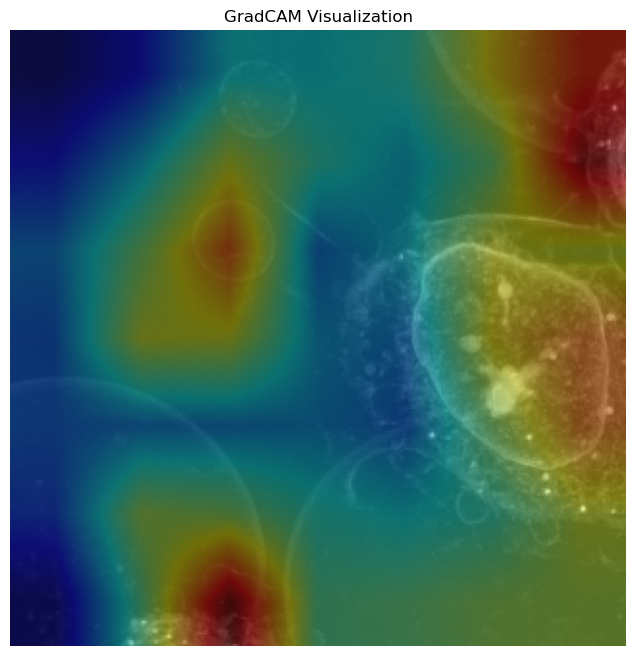

In [39]:
import torch
import torch.nn.functional as F
from torchvision import models
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Optimized GradCAM class with minimal hook overhead
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.target_layer.register_forward_hook(self.save_activation)
        # Use register_full_backward_hook if available
        self.target_layer.register_full_backward_hook(self.save_gradient)
        
    def save_activation(self, module, input, output):
        self.activations = output.detach()
        
    def save_gradient(self, module, grad_input, grad_output):
        # grad_output is a tuple; get the first element
        self.gradients = grad_output[0].detach()
        
    def __call__(self, input_tensor, class_idx=None):
        self.model.zero_grad()
        output = self.model(input_tensor)
        if class_idx is None:
            # For batch size 1, get the index for the first sample
            class_idx = output.argmax(dim=1).item()
        score = output[0, class_idx]
        score.backward()
        print("Activations stats:", self.activations.mean(), self.activations.std())
        print("Gradients stats:", self.gradients.mean(), self.gradients.std())
        # Compute weights: global-average-pool the gradients
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1, keepdim=True)
        cam = F.relu(cam)
        cam = F.interpolate(cam, size=input_tensor.shape[2:], mode='bilinear', align_corners=False)
        cam = cam.squeeze().cpu().numpy()
        # Normalize the heatmap
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        return cam

# Load and preprocess the image directly with PIL and torchvision transforms
transform = models.ResNet101_Weights.IMAGENET1K_V2.transforms()

path = r"C:\rkka_Projects\cell_death_v2\Data\model_training\mip\test\0_Necroptosis\necroptosis_test (22).png"
original_image = Image.open(path)
image = Image.open(path)
image = image.convert('L')
image = np.array(image)
image_tensor = torch.from_numpy(image).repeat(3,1,1).float()
image_tensor = transform(image_tensor)

# Load your model and send it to device
model = models.resnet101(pretrained=True)
num_features = model.fc.in_features
model.fc = torch.nn.Sequential(
    torch.nn.Dropout(0.2),
    torch.nn.Linear(num_features, 5)
)
model.load_state_dict(torch.load('test_0.9714.pth', map_location=device))
model = model.to(device)
model.eval()

# Use the last conv layer of ResNet101 as the target
target_layer = model.layer4[-1]  # instead of conv3 only
gradcam = GradCAM(model, target_layer)

# Generate the heatmap for the input image
heatmap = gradcam(image_tensor.unsqueeze(0).cuda())

# Resize heatmap to match original image dimensions
heatmap = cv2.resize(heatmap, (original_image.width, original_image.height))
heatmap = np.uint8(255 * heatmap)
heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# Convert original image to OpenCV format (BGR) for blending
original_cv = cv2.cvtColor(np.array(original_image), cv2.COLOR_RGB2BGR)
overlay = cv2.addWeighted(original_cv, 0.6, heatmap_color, 0.4, 0)

# Convert overlay to RGB for matplotlib display
overlay_rgb = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)

# Visualize the result with matplotlib
plt.figure(figsize=(10, 8))
plt.imshow(overlay_rgb)
plt.title('GradCAM Visualization')
plt.axis('off')
plt.show()


In [36]:
from torchvision import models

with torch.no_grad():
    output = model(image_tensor.unsqueeze(0).cuda())
    _, pred = torch.max(output, 1)
    
pred

tensor([0], device='cuda:0')

In [54]:
path = r"C:\rkka_Projects\cell_death_v2\Data\model_training_08h\mip\train\0_Apoptosis\230512.160429.CD95_TNF_Ctr.003.CD95.A1.T001P15_patch_3_t_16.png"
image = Image.open(path).convert('L')
image = np.array(image)
image_tensor = torch.from_numpy(image)
image_tensor = image_tensor.repeat(3,1,1).float()

transform = models.ResNet101_Weights.IMAGENET1K_V2.transforms()
image_tensor = transform(image_tensor)

model.eval()
with torch.no_grad():
    output = model(image_tensor.unsqueeze(0).cuda())
    _, pred = torch.max(output, 1)
    
pred

tensor([0], device='cuda:0')

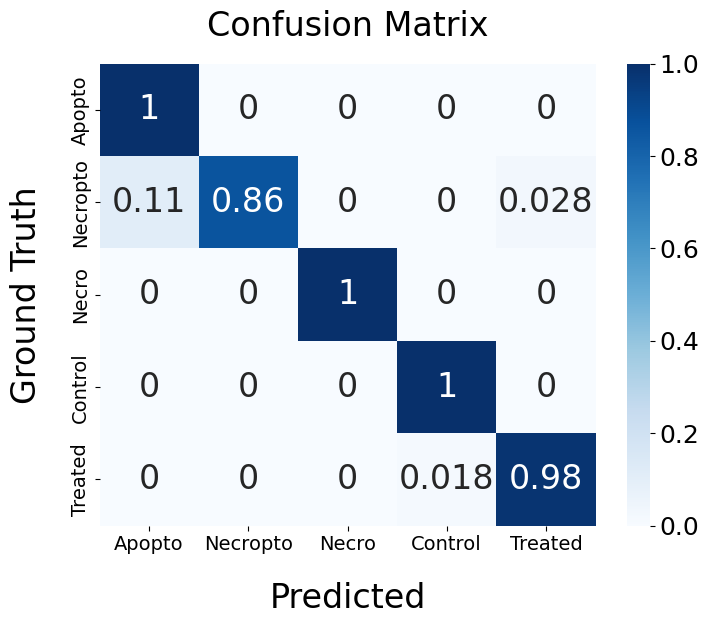

In [20]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

model = model.cuda()

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.cuda(), labels.cuda()

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
# Calculate confusion matrix
cm = confusion_matrix(all_labels, all_preds, normalize='true')

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", xticklabels=["Apopto", "Necropto", "Necro", "Control", "Treated"], 
                                          yticklabels=["Apopto", "Necropto", "Necro", "Control", "Treated"], annot_kws={'size': 24})
plt.xlabel("Predicted", fontsize=24, labelpad=20)
plt.ylabel("Ground Truth", fontsize=24, labelpad=20)
plt.title("Confusion Matrix", fontsize=24, pad=20)

# Adjust colorbar font size
cbar = plt.gca().collections[0].colorbar
cbar.ax.tick_params(labelsize=18)  # Set colorbar tick font size

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.savefig('figures/figure3/confusion_matrix.svg', format='svg', transparent=True)
plt.show()